### Oversampling (SMOTE + Undersampling)
- First, the dataset is oversampled using SMOTE, increasing the number of minority class samples using synthetic examples.
- Then, ENN is applied to the oversampled dataset to remove the synthetic examples that are too close to the majority class, reducing the risk of over-generalization.

For Fold 1:
Accuracy: 0.9741, Precision: 1.0000, Recall: 0.1038, F1-Score: 0.1880
--------------------------------------------------------------------------------
For Fold 2:
Accuracy: 0.9937, Precision: 0.7967, Recall: 0.9681, F1-Score: 0.8741
--------------------------------------------------------------------------------
For Fold 3:
Accuracy: 0.9780, Precision: 0.8925, Recall: 0.5673, F1-Score: 0.6937
--------------------------------------------------------------------------------
For Fold 4:
Accuracy: 0.9692, Precision: 0.9701, Recall: 0.4333, F1-Score: 0.5991
--------------------------------------------------------------------------------
For Fold 5:
Accuracy: 0.9708, Precision: 0.9146, Recall: 0.4978, F1-Score: 0.6447
--------------------------------------------------------------------------------


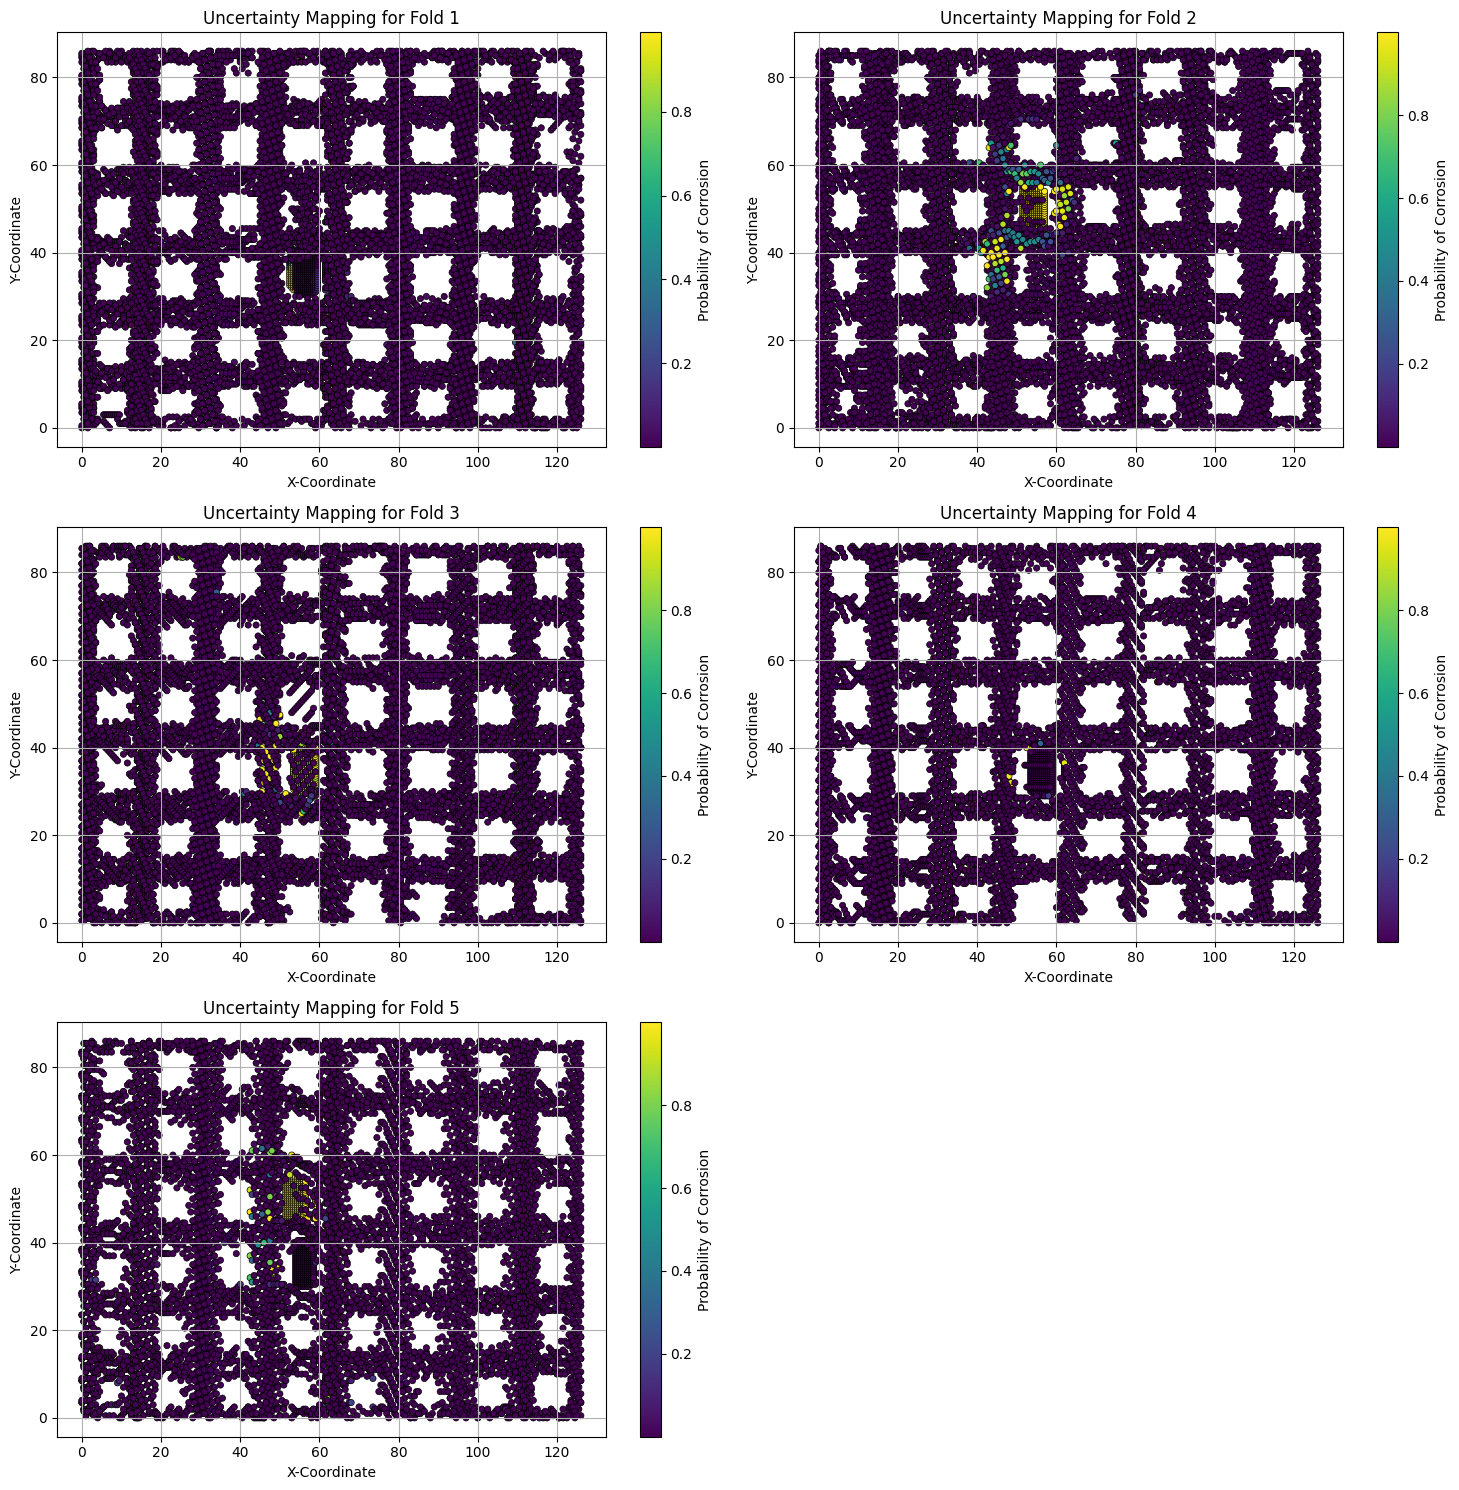

In [4]:
import xgboost as xgb
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Load the dataset
corrosion_data = pd.read_excel("open_crosion.xlsx")


smote_enn = SMOTEENN(random_state=42)

# Number of splits
n_splits = 5

# Instantiate GroupKFold
group_kfold = GroupKFold(n_splits=n_splits)

# Features and labels for the entire dataset
X = corrosion_data[['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7']]
y = corrosion_data['Label']
groups = corrosion_data['Experiment']


# Lists to store performance metrics for each fold
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1_scores = []

# List to store predicted probabilities for each fold for plotting
all_prob_corrosions = []
all_x_coords = []
all_y_coords = []

# Loop through each fold, train the model, make predictions, compute metrics, and plot
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    
    # Split data
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTEENN
    X_train_fold_resampled, y_train_fold_resampled = smote_enn.fit_resample(X_train_fold, y_train_fold)
    
    # Train XGBoost classifier
    xgb_classifier_fold = xgb.XGBClassifier(n_estimators=100, random_state=42)
    xgb_classifier_fold.fit(X_train_fold_resampled, y_train_fold_resampled)


    # Predictions
    predicted_labels_fold = xgb_classifier_fold.predict(X_test_fold)
    predicted_probs_fold = xgb_classifier_fold.predict_proba(X_test_fold)
    
    # Check if predicted_probs_fold has 2 columns (to avoid the previous error we encountered)
    if predicted_probs_fold.shape[1] == 2:
        prob_corrosion_fold = predicted_probs_fold[:, 1]
    else:
        prob_corrosion_fold = np.zeros_like(y_test_fold) if unique_predicted_labels[0] == 0 else np.ones_like(y_test_fold)
    
    all_prob_corrosions.append(prob_corrosion_fold)
    all_x_coords.append(corrosion_data.iloc[test_index]['X-Coordinate'].values)
    all_y_coords.append(corrosion_data.iloc[test_index]['Y-Coordinate'].values)
    
    # Compute performance metrics
    accuracy = accuracy_score(y_test_fold, predicted_labels_fold)
    precision = precision_score(y_test_fold, predicted_labels_fold)
    recall = recall_score(y_test_fold, predicted_labels_fold)
    f1 = f1_score(y_test_fold, predicted_labels_fold)
    
    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1_scores.append(f1)
    
    # Print metrics
    print(f"For Fold {i+1}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print("-" * 80)

# Plot the uncertainty for each fold
plt.figure(figsize=(15, 15))
for i in range(n_splits):
    plt.subplot(3, 2, i+1)
    sc = plt.scatter(all_x_coords[i], all_y_coords[i], c=all_prob_corrosions[i], cmap='viridis', s=20, edgecolor='k', linewidth=0.5)
    plt.colorbar(sc, label='Probability of Corrosion')
    plt.xlabel('X-Coordinate')
    plt.ylabel('Y-Coordinate')
    plt.title(f'Uncertainty Mapping for Fold {i+1}')
    plt.grid(True)

plt.tight_layout()
plt.show()

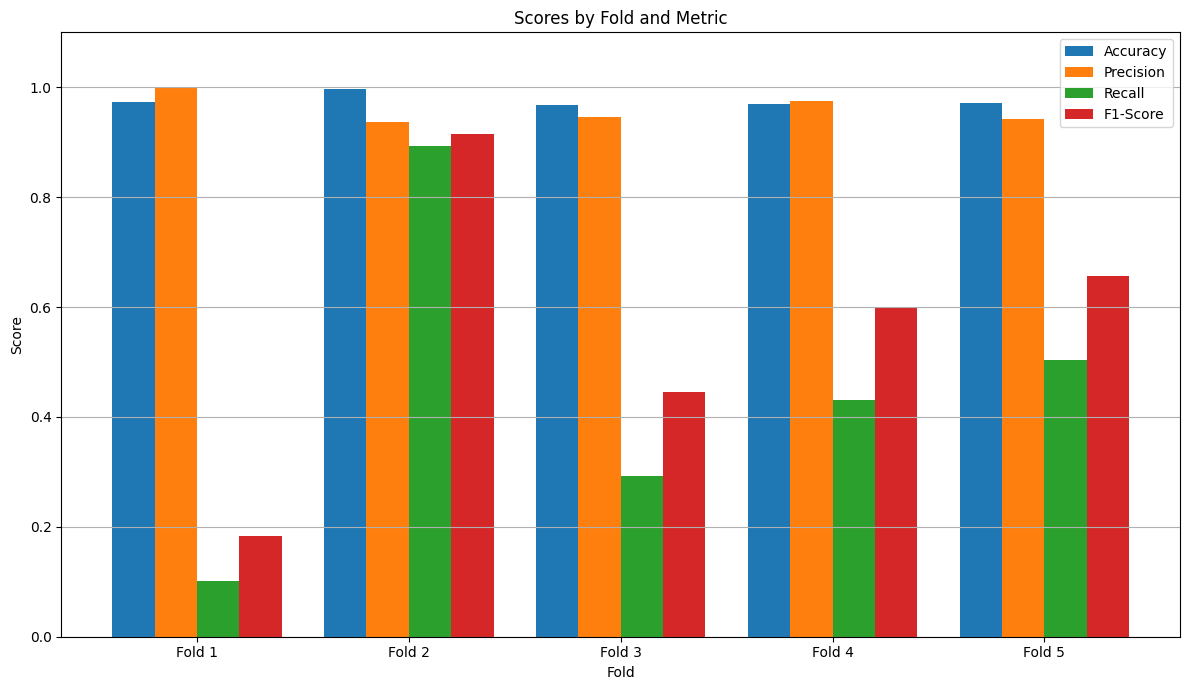

In [4]:
# Given data
folds = [f"Fold {i+1}" for i in range(n_splits)]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Values
values = [all_accuracies, all_precisions, all_recalls, all_f1_scores]

# Plotting
x = np.arange(len(folds))  # the fold labels locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
for i, (metric, value) in enumerate(zip(metrics, values)):
    ax.bar(x + i*width, value, width, label=metric)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Fold')
ax.set_ylabel('Score')
ax.set_title('Scores by Fold and Metric')
ax.set_xticks(x + width*(len(metrics)-1)/2)
ax.set_xticklabels(folds)
ax.legend()

ax.set_ylim([0, 1.1])  # Setting y-axis limits to [0, 1.1] to better visualize percentages
plt.tight_layout()
plt.grid(axis='y')
plt.show()


### XGBOOST - SMOTE

For Fold 1:
Accuracy: 0.9740, Precision: 1.0000, Recall: 0.1006, F1-Score: 0.1829
--------------------------------------------------------------------------------
For Fold 2:
Accuracy: 0.9962, Precision: 0.9372, Recall: 0.8924, F1-Score: 0.9143
--------------------------------------------------------------------------------
For Fold 3:
Accuracy: 0.9682, Precision: 0.9463, Recall: 0.2919, F1-Score: 0.4462
--------------------------------------------------------------------------------
For Fold 4:
Accuracy: 0.9692, Precision: 0.9749, Recall: 0.4311, F1-Score: 0.5978
--------------------------------------------------------------------------------
For Fold 5:
Accuracy: 0.9720, Precision: 0.9421, Recall: 0.5044, F1-Score: 0.6571
--------------------------------------------------------------------------------


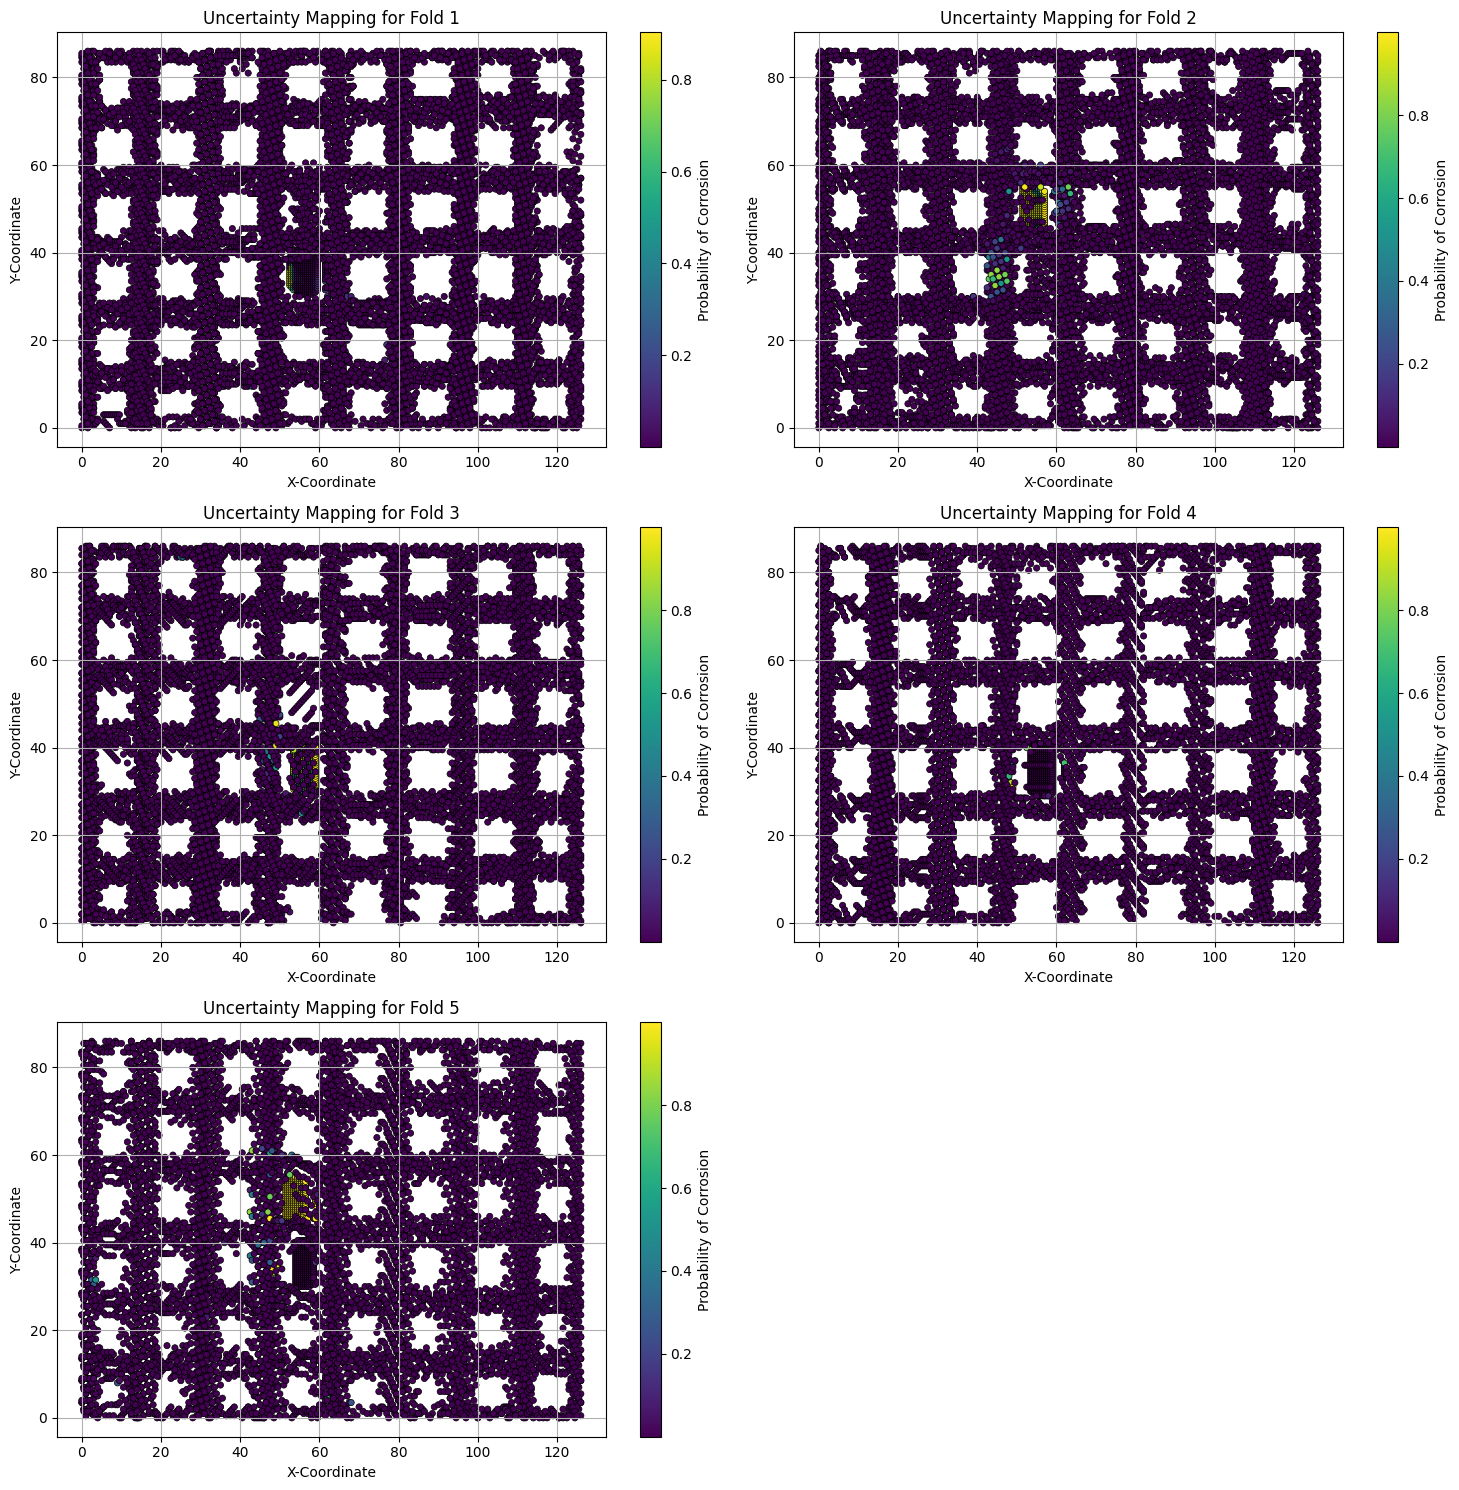

In [1]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold

import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the dataset
corrosion_data = pd.read_excel("open_crosion.xlsx")

smote = SMOTE(random_state=42)

# Number of splits
n_splits = 5

# Instantiate GroupKFold
group_kfold = GroupKFold(n_splits=n_splits)

# Features and labels for the entire dataset
X = corrosion_data[['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7']]
y = corrosion_data['Label']
groups = corrosion_data['Experiment']

# Lists to store performance metrics for each fold
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1_scores = []

# List to store predicted probabilities for each fold for plotting
all_prob_corrosions = []
all_x_coords = []
all_y_coords = []

# Loop through each fold, train the model, make predictions, compute metrics, and plot
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    
    # Split data
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Train XGBoost classifier
    xgb_classifier_fold = xgb.XGBClassifier(n_estimators=100, random_state=42)
    xgb_classifier_fold.fit(X_train_fold_resampled, y_train_fold_resampled)

    # Predictions
    predicted_labels_fold = xgb_classifier_fold.predict(X_test_fold)
    predicted_probs_fold = xgb_classifier_fold.predict_proba(X_test_fold)
    
    # Check if predicted_probs_fold has 2 columns (to avoid the previous error we encountered)
    if predicted_probs_fold.shape[1] == 2:
        prob_corrosion_fold = predicted_probs_fold[:, 1]
    else:
        prob_corrosion_fold = np.zeros_like(y_test_fold) if unique_predicted_labels[0] == 0 else np.ones_like(y_test_fold)
    
    all_prob_corrosions.append(prob_corrosion_fold)
    all_x_coords.append(corrosion_data.iloc[test_index]['X-Coordinate'].values)
    all_y_coords.append(corrosion_data.iloc[test_index]['Y-Coordinate'].values)
    
    # Compute performance metrics
    accuracy = accuracy_score(y_test_fold, predicted_labels_fold)
    precision = precision_score(y_test_fold, predicted_labels_fold)
    recall = recall_score(y_test_fold, predicted_labels_fold)
    f1 = f1_score(y_test_fold, predicted_labels_fold)
    
    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1_scores.append(f1)
    
    # Print metrics
    print(f"For Fold {i+1}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print("-" * 80)

# Plot the uncertainty for each fold
plt.figure(figsize=(15, 15))
for i in range(n_splits):
    plt.subplot(3, 2, i+1)
    sc = plt.scatter(all_x_coords[i], all_y_coords[i], c=all_prob_corrosions[i], cmap='viridis', s=20, edgecolor='k', linewidth=0.5)
    plt.colorbar(sc, label='Probability of Corrosion')
    plt.xlabel('X-Coordinate')
    plt.ylabel('Y-Coordinate')
    plt.title(f'Uncertainty Mapping for Fold {i+1}')
    plt.grid(True)

plt.tight_layout()
plt.show()


### Fold 1:
- Accuracy is high, but the recall is very low, which means that the model is missing a lot of the positive (corrosion) cases. The precision is high, which indicates that when the model predicts a corrosion event, it's highly likely to be correct.
### Fold 2:
- Both accuracy and precision are very high. The recall is also relatively high, indicating that the model is capturing a good number of positive cases.
### Fold 3:
- The accuracy is good, but the recall is low. Again, this indicates that the model is missing a lot of positive cases, even though its predictions for corrosion are mostly correct.
### Fold 4:
- The precision is very high, but the recall is less than half, which means the model is not capturing all the positive cases.
### Fold 5:
- The results here are balanced with both precision and recall being reasonably good, though there's still room for improvement in recall.

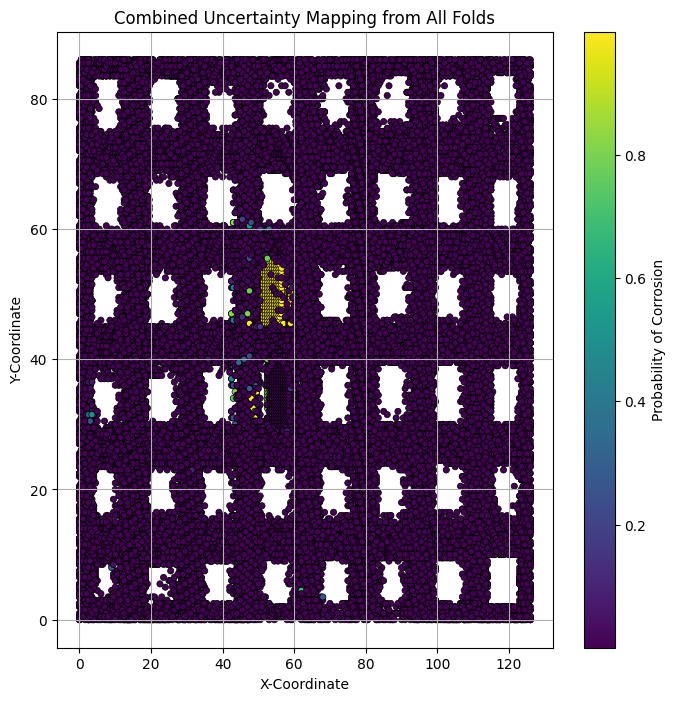

In [2]:
# Concatenate the x-coordinates, y-coordinates, and predicted probabilities from all folds
all_x = np.concatenate(all_x_coords)
all_y = np.concatenate(all_y_coords)
all_probs = np.concatenate(all_prob_corrosions)

# Plot the combined uncertainty mapping
plt.figure(figsize=(8, 8))
sc = plt.scatter(all_x, all_y, c=all_probs, cmap='viridis', s=20, edgecolor='k', linewidth=0.5)
plt.colorbar(sc, label='Probability of Corrosion')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.title('Combined Uncertainty Mapping from All Folds')
plt.grid(True)
plt.show()


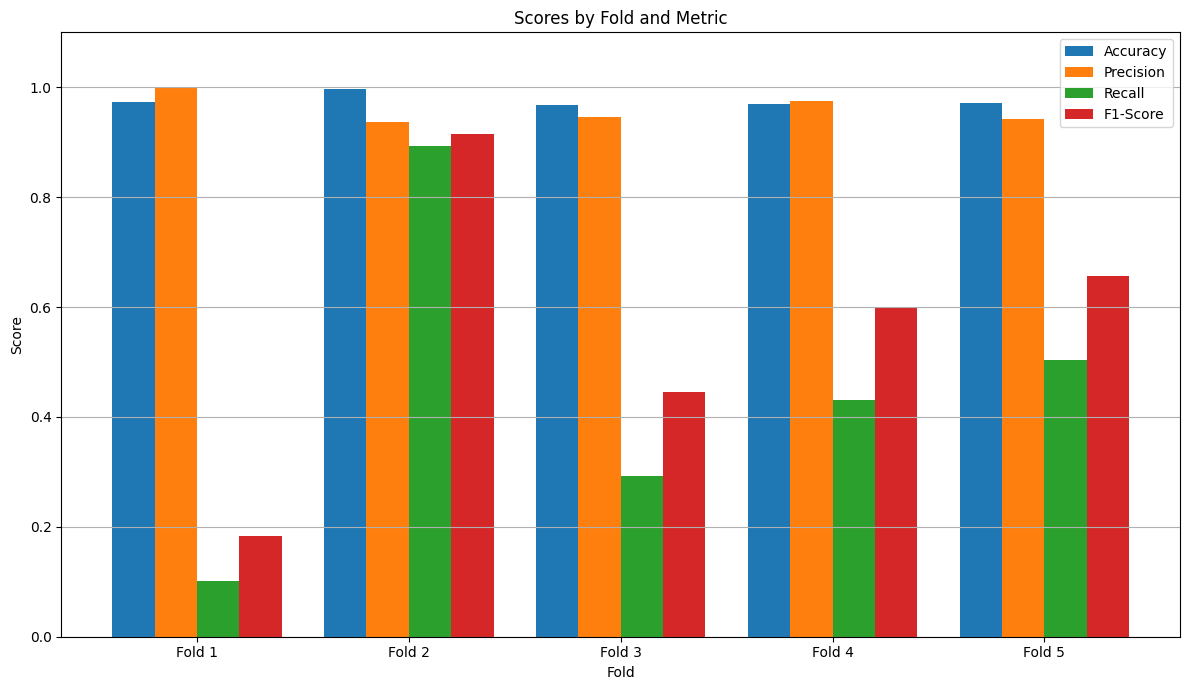

In [3]:
# Given data
folds = [f"Fold {i+1}" for i in range(n_splits)]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Values
values = [all_accuracies, all_precisions, all_recalls, all_f1_scores]

# Plotting
x = np.arange(len(folds))  # the fold labels locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
for i, (metric, value) in enumerate(zip(metrics, values)):
    ax.bar(x + i*width, value, width, label=metric)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Fold')
ax.set_ylabel('Score')
ax.set_title('Scores by Fold and Metric')
ax.set_xticks(x + width*(len(metrics)-1)/2)
ax.set_xticklabels(folds)
ax.legend()

ax.set_ylim([0, 1.1])  # Setting y-axis limits to [0, 1.1] to better visualize percentages
plt.tight_layout()
plt.grid(axis='y')
plt.show()


Experiments with predicted corrosion: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18]


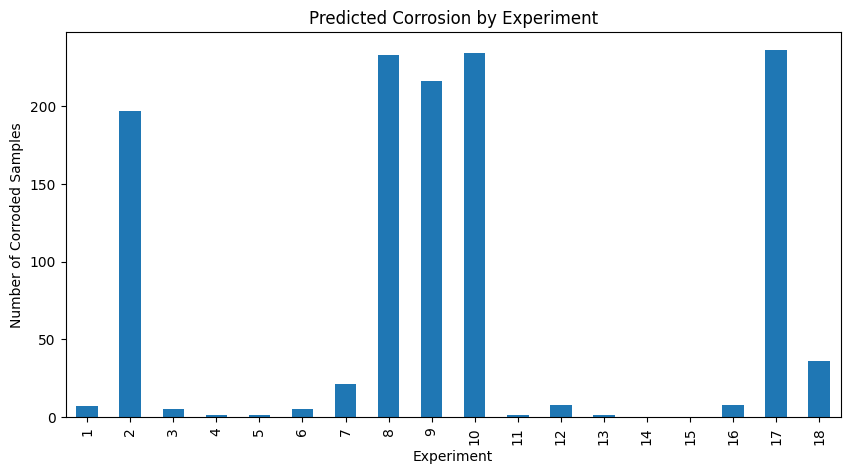

In [6]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold

import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the dataset
corrosion_data = pd.read_excel("open_crosion.xlsx")

smote = SMOTE(random_state=42)

# Number of splits
n_splits = 5

# Instantiate GroupKFold
group_kfold = GroupKFold(n_splits=n_splits)

# Features and labels for the entire dataset
X = corrosion_data[['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7']]
y = corrosion_data['Label']
groups = corrosion_data['Experiment']

# Lists to store performance metrics for each fold
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1_scores = []

# List to store predicted probabilities for each fold for plotting
all_prob_corrosions = []
all_x_coords = []
all_y_coords = []

# Lists to store predicted labels for each fold
all_predicted_labels = []

# Loop through each fold
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    # ... [rest of the code inside the loop]

   for idx, label in zip(test_index, predicted_labels_fold):
    all_predicted_labels.append((idx, label))

indices, labels = zip(*all_predicted_labels)
predicted_labels_series = pd.Series(labels, index=indices)

# Combine the predicted labels with the 'Experiment' column
combined_data = pd.concat([corrosion_data['Experiment'], predicted_labels_series], axis=1)
combined_data.columns = ['Experiment', 'Predicted_Label']

# Identify experiments with predicted corrosion
corroded_experiments = combined_data.groupby('Experiment').sum()
corroded_experiments = corroded_experiments[corroded_experiments['Predicted_Label'] > 0].index.tolist()

print("Experiments with predicted corrosion:", corroded_experiments)

# Plot the results
plt.figure(figsize=(10, 5))
combined_data.groupby('Experiment')['Predicted_Label'].sum().plot(kind='bar')
plt.ylabel('Number of Corroded Samples')
plt.title('Predicted Corrosion by Experiment')
plt.show()
